In [1]:
from collections import deque
import sys
sys.path.append('..')
import numpy as np
import torch
import torch.nn.functional as F
from models import *
from models.decode import mot_decode
from models.model import create_model, load_model
from models.utils import _tranpose_and_gather_feat
from tracker import matching
from tracking_utils.kalman_filter import KalmanFilter
from tracking_utils.log import logger
from tracking_utils.utils import *
from utils.post_process import ctdet_post_process

from basetrack import BaseTrack, TrackState


class STrack(BaseTrack):
    shared_kalman = KalmanFilter()
    def __init__(self, tlwh, score, temp_feat, buffer_size=30):

        # wait activate
        self._tlwh = np.asarray(tlwh, dtype=np.float)
        self.kalman_filter = None
        self.mean, self.covariance = None, None
        self.is_activated = False

        self.score = score
        self.tracklet_len = 0

        self.smooth_feat = None
        self.update_features(temp_feat)
        self.features = deque([], maxlen=buffer_size)
        self.alpha = 0.9

    def update_features(self, feat):
        feat /= np.linalg.norm(feat)
        self.curr_feat = feat
        if self.smooth_feat is None:
            self.smooth_feat = feat
        else:
            self.smooth_feat = self.alpha * self.smooth_feat + (1 - self.alpha) * feat
        self.features.append(feat)
        self.smooth_feat /= np.linalg.norm(self.smooth_feat)

    def predict(self):
        mean_state = self.mean.copy()
        if self.state != TrackState.Tracked:
            mean_state[7] = 0
        self.mean, self.covariance = self.kalman_filter.predict(mean_state, self.covariance)

    @staticmethod
    def multi_predict(stracks):
        if len(stracks) > 0:
            multi_mean = np.asarray([st.mean.copy() for st in stracks])
            multi_covariance = np.asarray([st.covariance for st in stracks])
            for i, st in enumerate(stracks):
                if st.state != TrackState.Tracked:
                    multi_mean[i][7] = 0
            multi_mean, multi_covariance = STrack.shared_kalman.multi_predict(multi_mean, multi_covariance)
            for i, (mean, cov) in enumerate(zip(multi_mean, multi_covariance)):
                stracks[i].mean = mean
                stracks[i].covariance = cov

    def activate(self, kalman_filter, frame_id):
        """Start a new tracklet"""
        self.kalman_filter = kalman_filter
        self.track_id = self.next_id()
        self.mean, self.covariance = self.kalman_filter.initiate(self.tlwh_to_xyah(self._tlwh))

        self.tracklet_len = 0
        self.state = TrackState.Tracked
        #self.is_activated = True
        self.frame_id = frame_id
        self.start_frame = frame_id

    def re_activate(self, new_track, frame_id, new_id=False):
        self.mean, self.covariance = self.kalman_filter.update(
            self.mean, self.covariance, self.tlwh_to_xyah(new_track.tlwh)
        )

        self.update_features(new_track.curr_feat)
        self.tracklet_len = 0
        self.state = TrackState.Tracked
        self.is_activated = True
        self.frame_id = frame_id
        if new_id:
            self.track_id = self.next_id()

    def update(self, new_track, frame_id, update_feature=True):
        """
        Update a matched track
        :type new_track: STrack
        :type frame_id: int
        :type update_feature: bool
        :return:
        """
        self.frame_id = frame_id
        self.tracklet_len += 1

        new_tlwh = new_track.tlwh
        self.mean, self.covariance = self.kalman_filter.update(
            self.mean, self.covariance, self.tlwh_to_xyah(new_tlwh))
        self.state = TrackState.Tracked
        self.is_activated = True

        self.score = new_track.score
        if update_feature:
            self.update_features(new_track.curr_feat)

    @property
    # @jit(nopython=True)
    def tlwh(self):
        """Get current position in bounding box format `(top left x, top left y,
                width, height)`.
        """
        if self.mean is None:
            return self._tlwh.copy()
        ret = self.mean[:4].copy()
        ret[2] *= ret[3]
        ret[:2] -= ret[2:] / 2
        return ret

    @property
    # @jit(nopython=True)
    def tlbr(self):
        """Convert bounding box to format `(min x, min y, max x, max y)`, i.e.,
        `(top left, bottom right)`.
        """
        ret = self.tlwh.copy()
        ret[2:] += ret[:2]
        return ret

    @staticmethod
    # @jit(nopython=True)
    def tlwh_to_xyah(tlwh):
        """Convert bounding box to format `(center x, center y, aspect ratio,
        height)`, where the aspect ratio is `width / height`.
        """
        ret = np.asarray(tlwh).copy()
        ret[:2] += ret[2:] / 2
        ret[2] /= ret[3]
        return ret

    def to_xyah(self):
        return self.tlwh_to_xyah(self.tlwh)

    @staticmethod
    # @jit(nopython=True)
    def tlbr_to_tlwh(tlbr):
        ret = np.asarray(tlbr).copy()
        ret[2:] -= ret[:2]
        return ret

    @staticmethod
    # @jit(nopython=True)
    def tlwh_to_tlbr(tlwh):
        ret = np.asarray(tlwh).copy()
        ret[2:] += ret[:2]
        return ret

    def __repr__(self):
        return 'OT_{}_({}-{})'.format(self.track_id, self.start_frame, self.end_frame)


class JDETracker(object):
    def __init__(self, opt, frame_rate=30):
        self.opt = opt
        if opt.gpus[0] >= 0:
            opt.device = torch.device('cuda')
        else:
            opt.device = torch.device('cpu')
        print('Creating model...')
        self.model = create_model(opt.arch, opt.heads, opt.head_conv)
        self.model = load_model(self.model, opt.load_model)
        self.model = self.model.to(opt.device)
        self.model.eval()

        self.tracked_stracks = []  # type: list[STrack]
        self.lost_stracks = []  # type: list[STrack]
        self.removed_stracks = []  # type: list[STrack]

        self.frame_id = 0
        self.det_thresh = opt.conf_thres
        self.buffer_size = int(frame_rate / 30.0 * opt.track_buffer)
        self.max_time_lost = self.buffer_size
        self.max_per_image = opt.K
        self.mean = np.array(opt.mean, dtype=np.float32).reshape(1, 1, 3)
        self.std = np.array(opt.std, dtype=np.float32).reshape(1, 1, 3)

        self.kalman_filter = KalmanFilter()

    def post_process(self, dets, meta):
        dets = dets.detach().cpu().numpy()
        dets = dets.reshape(1, -1, dets.shape[2])
        dets = ctdet_post_process(
            dets.copy(), [meta['c']], [meta['s']],
            meta['out_height'], meta['out_width'], self.opt.num_classes)
        for j in range(1, self.opt.num_classes + 1):
            dets[0][j] = np.array(dets[0][j], dtype=np.float32).reshape(-1, 5)
        return dets[0]

    def merge_outputs(self, detections):
        results = {}
        for j in range(1, self.opt.num_classes + 1):
            results[j] = np.concatenate(
                [detection[j] for detection in detections], axis=0).astype(np.float32)

        scores = np.hstack(
            [results[j][:, 4] for j in range(1, self.opt.num_classes + 1)])
        if len(scores) > self.max_per_image:
            kth = len(scores) - self.max_per_image
            thresh = np.partition(scores, kth)[kth]
            for j in range(1, self.opt.num_classes + 1):
                keep_inds = (results[j][:, 4] >= thresh)
                results[j] = results[j][keep_inds]
        return results

    def update(self, im_blob, img0):
        self.frame_id += 1
        activated_starcks = []
        refind_stracks = []
        lost_stracks = []
        removed_stracks = []

        width = img0.shape[1]
        height = img0.shape[0]
        inp_height = im_blob.shape[2]
        inp_width = im_blob.shape[3]
        c = np.array([width / 2., height / 2.], dtype=np.float32)
        s = max(float(inp_width) / float(inp_height) * height, width) * 1.0
        meta = {'c': c, 's': s,
                'out_height': inp_height // self.opt.down_ratio,
                'out_width': inp_width // self.opt.down_ratio}

        ''' Step 1: Network forward, get detections & embeddings'''
        with torch.no_grad():
            output = self.model(im_blob)[-1]
            hm = output['hm'].sigmoid_()
            wh = output['wh']
            id_feature = output['id']
            id_feature = F.normalize(id_feature, dim=1)

            reg = output['reg'] if self.opt.reg_offset else None
            dets, inds = mot_decode(hm, wh, reg=reg, cat_spec_wh=self.opt.cat_spec_wh, K=self.opt.K)
            id_feature = _tranpose_and_gather_feat(id_feature, inds)
            id_feature = id_feature.squeeze(0)
            id_feature = id_feature.cpu().numpy()

        dets = self.post_process(dets, meta)
        dets = self.merge_outputs([dets])[1]

        remain_inds = dets[:, 4] > self.opt.conf_thres
        dets = dets[remain_inds]
        id_feature = id_feature[remain_inds]

        # vis
        '''
        for i in range(0, dets.shape[0]):
            bbox = dets[i][0:4]
            cv2.rectangle(img0, (bbox[0], bbox[1]),
                          (bbox[2], bbox[3]),
                          (0, 255, 0), 2)
        cv2.imshow('dets', img0)
        cv2.waitKey(0)
        id0 = id0-1
        '''

        if len(dets) > 0:
            '''Detections'''
            detections = [STrack(STrack.tlbr_to_tlwh(tlbrs[:4]), tlbrs[4], f, 30) for
                          (tlbrs, f) in zip(dets[:, :5], id_feature)]
        else:
            detections = []

        ''' Add newly detected tracklets to tracked_stracks'''
        unconfirmed = []
        tracked_stracks = []  # type: list[STrack]
        for track in self.tracked_stracks:
            if not track.is_activated:
                unconfirmed.append(track)
            else:
                tracked_stracks.append(track)

        ''' Step 2: First association, with embedding'''
        strack_pool = joint_stracks(tracked_stracks, self.lost_stracks)
        # Predict the current location with KF
        #for strack in strack_pool:
            #strack.predict()
        STrack.multi_predict(strack_pool)
        dists = matching.embedding_distance(strack_pool, detections)
        #dists = matching.gate_cost_matrix(self.kalman_filter, dists, strack_pool, detections)
        dists = matching.fuse_motion(self.kalman_filter, dists, strack_pool, detections)
        matches, u_track, u_detection = matching.linear_assignment(dists, thresh=0.7)

        for itracked, idet in matches:
            track = strack_pool[itracked]
            det = detections[idet]
            if track.state == TrackState.Tracked:
                track.update(detections[idet], self.frame_id)
                activated_starcks.append(track)
            else:
                track.re_activate(det, self.frame_id, new_id=False)
                refind_stracks.append(track)

        ''' Step 3: Second association, with IOU'''
        detections = [detections[i] for i in u_detection]
        r_tracked_stracks = [strack_pool[i] for i in u_track if strack_pool[i].state == TrackState.Tracked]
        dists = matching.iou_distance(r_tracked_stracks, detections)
        matches, u_track, u_detection = matching.linear_assignment(dists, thresh=0.5)

        for itracked, idet in matches:
            track = r_tracked_stracks[itracked]
            det = detections[idet]
            if track.state == TrackState.Tracked:
                track.update(det, self.frame_id)
                activated_starcks.append(track)
            else:
                track.re_activate(det, self.frame_id, new_id=False)
                refind_stracks.append(track)

        for it in u_track:
            track = r_tracked_stracks[it]
            if not track.state == TrackState.Lost:
                track.mark_lost()
                lost_stracks.append(track)

        '''Deal with unconfirmed tracks, usually tracks with only one beginning frame'''
        detections = [detections[i] for i in u_detection]
        dists = matching.iou_distance(unconfirmed, detections)
        matches, u_unconfirmed, u_detection = matching.linear_assignment(dists, thresh=0.7)
        for itracked, idet in matches:
            unconfirmed[itracked].update(detections[idet], self.frame_id)
            activated_starcks.append(unconfirmed[itracked])
        for it in u_unconfirmed:
            track = unconfirmed[it]
            track.mark_removed()
            removed_stracks.append(track)

        """ Step 4: Init new stracks"""
        for inew in u_detection:
            track = detections[inew]
            if track.score < self.det_thresh:
                continue
            track.activate(self.kalman_filter, self.frame_id)
            activated_starcks.append(track)
        """ Step 5: Update state"""
        for track in self.lost_stracks:
            if self.frame_id - track.end_frame > self.max_time_lost:
                track.mark_removed()
                removed_stracks.append(track)

        # print('Ramained match {} s'.format(t4-t3))

        self.tracked_stracks = [t for t in self.tracked_stracks if t.state == TrackState.Tracked]
        self.tracked_stracks = joint_stracks(self.tracked_stracks, activated_starcks)
        self.tracked_stracks = joint_stracks(self.tracked_stracks, refind_stracks)
        self.lost_stracks = sub_stracks(self.lost_stracks, self.tracked_stracks)
        self.lost_stracks.extend(lost_stracks)
        self.lost_stracks = sub_stracks(self.lost_stracks, self.removed_stracks)
        self.removed_stracks.extend(removed_stracks)
        self.tracked_stracks, self.lost_stracks = remove_duplicate_stracks(self.tracked_stracks, self.lost_stracks)
        # get scores of lost tracks
        output_stracks = [track for track in self.tracked_stracks if track.is_activated]

        logger.debug('===========Frame {}=========='.format(self.frame_id))
        logger.debug('Activated: {}'.format([track.track_id for track in activated_starcks]))
        logger.debug('Refind: {}'.format([track.track_id for track in refind_stracks]))
        logger.debug('Lost: {}'.format([track.track_id for track in lost_stracks]))
        logger.debug('Removed: {}'.format([track.track_id for track in removed_stracks]))

        return output_stracks


def joint_stracks(tlista, tlistb):
    exists = {}
    res = []
    for t in tlista:
        exists[t.track_id] = 1
        res.append(t)
    for t in tlistb:
        tid = t.track_id
        if not exists.get(tid, 0):
            exists[tid] = 1
            res.append(t)
    return res


def sub_stracks(tlista, tlistb):
    stracks = {}
    for t in tlista:
        stracks[t.track_id] = t
    for t in tlistb:
        tid = t.track_id
        if stracks.get(tid, 0):
            del stracks[tid]
    return list(stracks.values())


def remove_duplicate_stracks(stracksa, stracksb):
    pdist = matching.iou_distance(stracksa, stracksb)
    pairs = np.where(pdist < 0.15)
    dupa, dupb = list(), list()
    for p, q in zip(*pairs):
        timep = stracksa[p].frame_id - stracksa[p].start_frame
        timeq = stracksb[q].frame_id - stracksb[q].start_frame
        if timep > timeq:
            dupb.append(q)
        else:
            dupa.append(p)
    resa = [t for i, t in enumerate(stracksa) if not i in dupa]
    resb = [t for i, t in enumerate(stracksb) if not i in dupb]
    return resa, resb


In [2]:
heads = {'hm': 1,
                   'wh': 2 ,
                   'id': 512,
        'reg': 2}

In [3]:
model = create_model('dla_34',heads,256)

In [4]:
model = load_model(model,'../../../models/all_dla34.pth')

loaded ../../../models/all_dla34.pth, epoch 10


In [5]:
model_path = '../../../models/all_dla34.pth'

In [40]:
state_dict = model.state_dict()

In [41]:
checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)

In [42]:
state_dict_ = checkpoint['state_dict']

In [22]:
# state_dict_

In [43]:
state_dict = {}

In [44]:
for k in state_dict_:
    if k.startswith('module') and not k.startswith('module_list'):
        print('Yay')
    else:
        state_dict[k] = state_dict_[k]

In [45]:
len(state_dict.keys())

404

In [46]:
model_state_dict = model.state_dict()

In [47]:
len(model_state_dict.keys())

404

In [30]:
for k in state_dict:
    if k in model_state_dict:
        if state_dict[k].shape != model_state_dict[k].shape:
            print('Skip loading parameter {}, required shape{}, '\
                  'loaded shape{}. {}'.format(
              k, model_state_dict[k].shape, state_dict[k].shape, msg))
            state_dict[k] = model_state_dict[k]
    else:
          print('Drop parameter {}.'.format(k) + msg)

400

In [48]:
for k in state_dict:
    if k not in model_state_dict:
        print(k)

In [7]:
model = model.to(torch.device('cuda'))
model.eval();

In [10]:
def letterbox(img, height=608, width=1088,
              color=(127.5, 127.5, 127.5)):  # resize a rectangular image to a padded rectangular
    shape = img.shape[:2]  # shape = [height, width]
    ratio = min(float(height) / shape[0], float(width) / shape[1])
    new_shape = (round(shape[1] * ratio), round(shape[0] * ratio))  # new_shape = [width, height]
    dw = (width - new_shape[0]) / 2  # width padding
    dh = (height - new_shape[1]) / 2  # height padding
    top, bottom = round(dh - 0.1), round(dh + 0.1)
    left, right = round(dw - 0.1), round(dw + 0.1)
    img = cv2.resize(img, new_shape, interpolation=cv2.INTER_AREA)  # resized, no border
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # padded rectangular
    return img, ratio, dw, dh

In [8]:
import cv2

In [99]:
img = cv2.imread('8620050-4x3-940x705.jpg')


In [11]:
im,x,y,z = letterbox(img)

In [12]:
import matplotlib.pyplot as plt

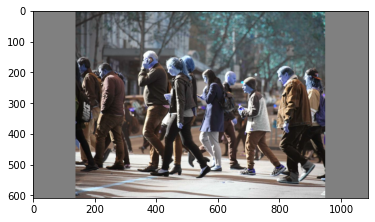

In [13]:
plt.imshow(im)

TypeError: Invalid shape (3, 608, 1088) for image data

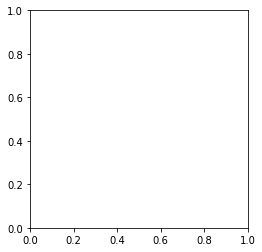

In [98]:
plt.imshow(img)

In [18]:
img = im[:, :, ::-1].transpose(2, 0, 1)
img = np.ascontiguousarray(img, dtype=np.float32)
img /= 255.0

In [19]:
img.shape

(3, 608, 1088)

In [21]:
bolb = torch.from_numpy(img).cuda().unsqueeze(0)

In [23]:
bolb.shape

torch.Size([1, 3, 608, 1088])

In [25]:
with torch.no_grad():
    out = model(bolb)

In [31]:
out[0]['wh'].shape

torch.Size([1, 2, 152, 272])

In [34]:
out[0]['id'].shape

torch.Size([1, 512, 152, 272])

In [35]:
out[0]['reg'].shape

torch.Size([1, 2, 152, 272])

In [36]:
out[0]['hm'].shape

torch.Size([1, 1, 152, 272])

In [40]:
hm = out[0]['hm']

In [42]:
hm = hm.sigmoid()

In [44]:
output = out[0]

In [57]:
wh = output['wh']
id_feature = output['id']
id_feature = F.normalize(id_feature, dim=1)

reg = output['reg']
# dets, inds = mot_decode(hm, wh, reg=reg, cat_spec_wh=self.opt.cat_spec_wh, K=self.opt.K)
# id_feature = _tranpose_and_gather_feat(id_feature, inds)
# id_feature = id_feature.squeeze(0)
# id_feature = id_feature.cpu().numpy()


In [65]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn
sys.path.append('../models')
from models.utils import _gather_feat, _tranpose_and_gather_feat

def _nms(heat, kernel=3):
    pad = (kernel - 1) // 2

    hmax = nn.functional.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=pad)
    keep = (hmax == heat).float()
    return heat * keep


def _topk_channel(scores, K=40):
      batch, cat, height, width = scores.size()
      
      topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)

      topk_inds = topk_inds % (height * width)
      topk_ys   = (topk_inds / width).int().float()
      topk_xs   = (topk_inds % width).int().float()

      return topk_scores, topk_inds, topk_ys, topk_xs

def _topk(scores, K=40):
    batch, cat, height, width = scores.size()
      
    topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)

    topk_inds = topk_inds % (height * width)
    topk_ys   = (topk_inds / width).int().float()
    topk_xs   = (topk_inds % width).int().float()
      
    topk_score, topk_ind = torch.topk(topk_scores.view(batch, -1), K)
    topk_clses = (topk_ind / K).int()
    topk_inds = _gather_feat(
        topk_inds.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_ys = _gather_feat(topk_ys.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_xs = _gather_feat(topk_xs.view(batch, -1, 1), topk_ind).view(batch, K)

    return topk_score, topk_inds, topk_clses, topk_ys, topk_xs


In [60]:
def mot_decode(heat, wh, reg=None, cat_spec_wh=False, K=100):
    batch, cat, height, width = heat.size()

    # heat = torch.sigmoid(heat)
    # perform nms on heatmaps
    heat = _nms(heat)

    scores, inds, clses, ys, xs = _topk(heat, K=K)
    if reg is not None:
        reg = _tranpose_and_gather_feat(reg, inds)
        reg = reg.view(batch, K, 2)
        xs = xs.view(batch, K, 1) + reg[:, :, 0:1]
        ys = ys.view(batch, K, 1) + reg[:, :, 1:2]
    else:
        xs = xs.view(batch, K, 1) + 0.5
        ys = ys.view(batch, K, 1) + 0.5
    wh = _tranpose_and_gather_feat(wh, inds)
    if cat_spec_wh:
        wh = wh.view(batch, K, cat, 2)
        clses_ind = clses.view(batch, K, 1, 1).expand(batch, K, 1, 2).long()
        wh = wh.gather(2, clses_ind).view(batch, K, 2)
    else:
        wh = wh.view(batch, K, 2)
    clses = clses.view(batch, K, 1).float()
    scores = scores.view(batch, K, 1)
    bboxes = torch.cat([xs - wh[..., 0:1] / 2,
                        ys - wh[..., 1:2] / 2,
                        xs + wh[..., 0:1] / 2,
                        ys + wh[..., 1:2] / 2], dim=2)
    detections = torch.cat([bboxes, scores, clses], dim=2)

    return detections, inds


In [66]:
dets, inds = mot_decode(hm, wh, reg=reg, cat_spec_wh=True, K=128)

In [85]:
id_feature = _tranpose_and_gather_feat(id_feature, inds)

In [86]:
id_feature.shape

torch.Size([1, 128, 512])

In [87]:
id_feature = id_feature.cpu().numpy()

In [88]:
dets.shape

torch.Size([1, 128, 6])

In [89]:
dets = dets.detach().cpu().numpy()
dets = dets.reshape(1, -1, dets.shape[2])

In [90]:
dets.shape

(1, 128, 6)

In [92]:
from collections import deque

import numpy as np
import torch
import torch.nn.functional as F
from models import *
from models.decode import mot_decode
from models.model import create_model, load_model
from models.utils import _tranpose_and_gather_feat
from tracker import matching
from tracking_utils.kalman_filter import KalmanFilter
from tracking_utils.log import logger
from tracking_utils.utils import *
from utils.post_process import ctdet_post_process

In [108]:
def post_process( dets, meta):
    dets = dets
    dets = dets.reshape(1, -1, dets.shape[2])
    dets = ctdet_post_process(
        dets.copy(), [meta['c']], [meta['s']],
        meta['out_height'], meta['out_width'], 1)
    for j in range(1, 1 + 1):
        dets[0][j] = np.array(dets[0][j], dtype=np.float32).reshape(-1, 5)
    return dets[0]

In [94]:
inp_height = bolb.shape[2]
inp_width = bolb.shape[3]

In [100]:
width = img.shape[1]
height = img.shape[0]

In [101]:
c = np.array([width / 2., height / 2.], dtype=np.float32)
s = max(float(inp_width) / float(inp_height) * height, width) * 1.0

1261.578947368421

In [104]:
meta = {'c': c, 's': s,
                'out_height': inp_height // 4,
                'out_width': inp_width // 4}

In [109]:
det_new = post_process(dets,meta)

In [117]:
def merge_outputs( detections):
    results = {}
    for j in range(1, 1 + 1):
        results[j] = np.concatenate(
            [detection[j] for detection in detections], axis=0).astype(np.float32)

    scores = np.hstack(
        [results[j][:, 4] for j in range(1, 1 + 1)])
    if len(scores) > 128:
        kth = len(scores) - 128
        thresh = np.partition(scores, kth)[kth]
        for j in range(1, 1 + 1):
            keep_inds = (results[j][:, 4] >= thresh)
            results[j] = results[j][keep_inds]
    return results

In [119]:
det_new2 = merge_outputs([det_new])

In [123]:
det_new2[1].shape

(128, 5)

In [136]:
remain_inds = det_new2[1][:, 4] > 0.5
dets = det_new2[1][remain_inds]

id_feature = id_feature[remain_inds]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 7 but corresponding boolean dimension is 128

In [134]:
remain_inds.shape

(128,)

In [137]:
id_feature.shape

(7, 512)

In [138]:
id_feature

array([[  -0.041839,    0.026876,    0.048106, ...,    0.020356,   0.0089655,   -0.059829],
       [  -0.035864,    0.013832,    0.045459, ...,  -0.0041401,   0.0049192,   -0.081788],
       [   0.020093,     0.04063,    0.051501, ...,   -0.042466,    0.066014,   -0.033385],
       ...,
       [ -0.0070784,   -0.011395,    0.036654, ...,    0.030213,    0.049186,   -0.092264],
       [  -0.032154,    0.037467,     0.04895, ..., -4.1478e-05,    0.047282,   -0.022843],
       [  0.0025548,    0.018067,    0.035393, ...,    -0.05232,    0.052697,  -0.0090622]], dtype=float32)

In [140]:
dets.shape

(8, 5)